# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow tensorflow-io==0.36.0 matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 14.3 MB/s eta 0:00:00


In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


## 1.2 Load Dependencies

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [ ]:
!dir

drive  sample_data


In [ ]:
VISHING_CALL_AUDIO = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/Vishing_calls_snippets/XC114131-0.wav')
LEGITIMATE_CALL_AUDIO = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/Normal_call_snippets/01.wav')

## 2.2 Build Dataloading Function

In [ ]:
def load_wav_16k_mono(filename):
    #Load encoded wav file
    file_contents = tf.io.read_file(filename)
    #Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    #wav, sample_rate=librosa.load(filename, sr=16000, dtype=np.float32)

    # Removes trailing axis
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    #Goes from 44100Hz to 16000Hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot wave

In [ ]:
wave = load_wav_16k_mono(VISHING_CALL_AUDIO)
nwave = load_wav_16k_mono(LEGITIMATE_CALL_AUDIO)

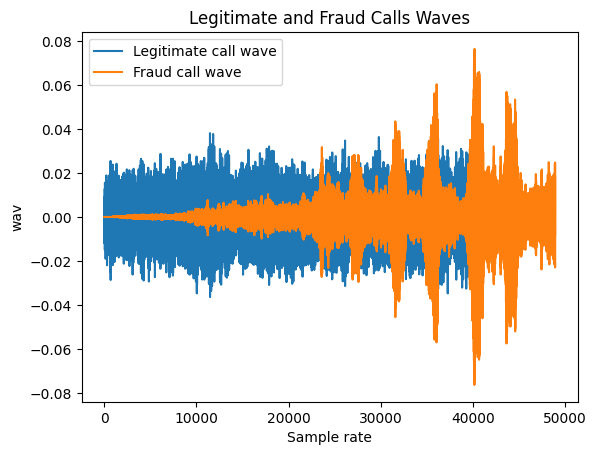

In [ ]:
plt.plot(wave, label='Legitimate call wave')
plt.plot(nwave, label='Fraud call wave')
plt.legend()  # Add legend to the plot
plt.title("Legitimate and Fraud Calls Waves")
plt.xlabel('Sample rate')
plt.ylabel('wav')
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [ ]:
POS = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/Vishing_calls_snippets')
NEG = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/Normal_call_snippets')

## 3.2 Create Tensorflow Datasets

In [ ]:
pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Vishing Call

## 4.1 Calculate Wave Cycle Length

In [ ]:
lengths = []
for file in os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/data/Vishing_calls_snippets')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/Colab Notebooks/data/Vishing_calls_snippets', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
54156/16000

3.38475

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Visualize the Spectrogram

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

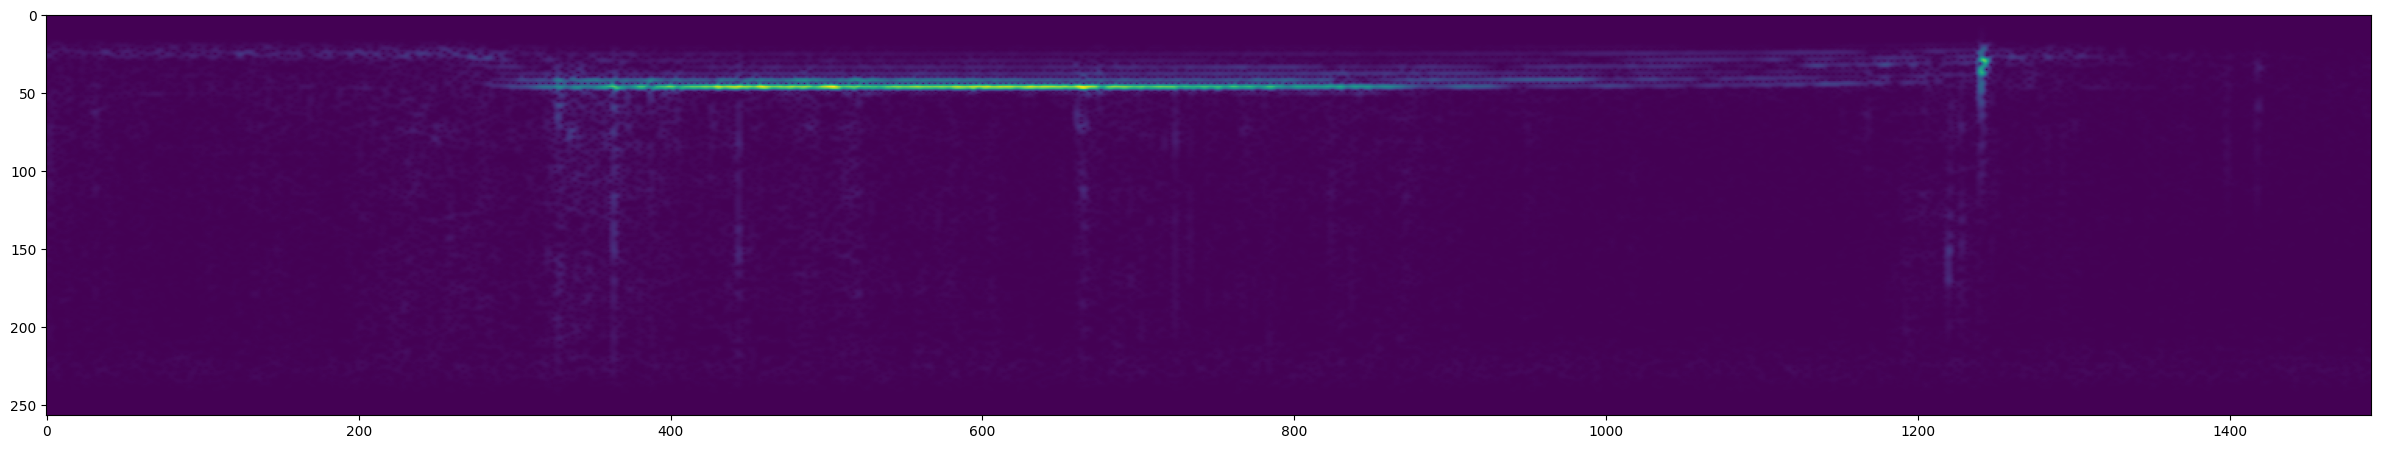

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [ ]:
train = data.take(22)
test = data.skip(22).take(9)

In [ ]:
len(data)*0.70

21.7

## 6.3 Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=['accuracy', tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 744, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 371, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 368032)            0         
                                                                 
 dense (Dense)               (None, 128)               4

## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
22/22 [==============================] - 123s 5s/step - loss: 0.9459 - accuracy: 0.9091 - recall: 0.9299 - precision: 0.8743 - val_loss: 0.3816 - val_accuracy: 0.9710 - val_recall: 0.9667 - val_precision: 0.9667
Epoch 2/4
22/22 [==============================] - 118s 5s/step - loss: 0.2354 - accuracy: 0.9773 - recall: 0.9753 - precision: 0.9753 - val_loss: 0.0429 - val_accuracy: 0.9928 - val_recall: 0.9831 - val_precision: 1.0000
Epoch 3/4
22/22 [==============================] - 119s 5s/step - loss: 0.0303 - accuracy: 0.9915 - recall: 0.9877 - precision: 0.9938 - val_loss: 0.0196 - val_accuracy: 0.9928 - val_recall: 0.9848 - val_precision: 1.0000
Epoch 4/4
22/22 [==============================] - 117s 5s/step - loss: 0.0062 - accuracy: 0.9972 - recall: 1.0000 - precision: 0.9933 - val_loss: 0.0013 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000


In [ ]:
print("Accuracy:", hist.history['accuracy'][-1])  # Assuming accuracy is stored in 'accuracy' and retrieves last epoch value
print("Precision:", hist.history['precision'][-1])  # Assuming precision was calculated and stored in a list
print("Recall:", hist.history['recall'][-1])



Accuracy: 0.9971590638160706
Precision: 0.9932885766029358
Recall: 1.0


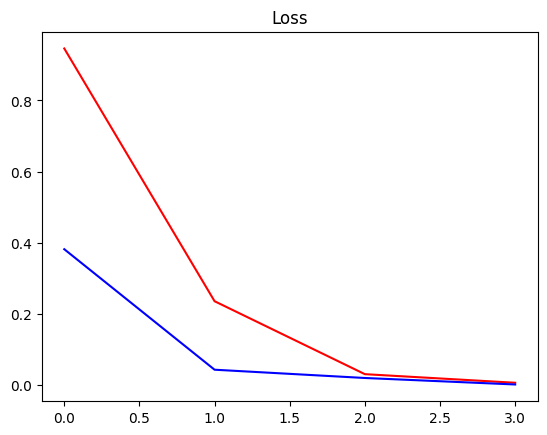

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

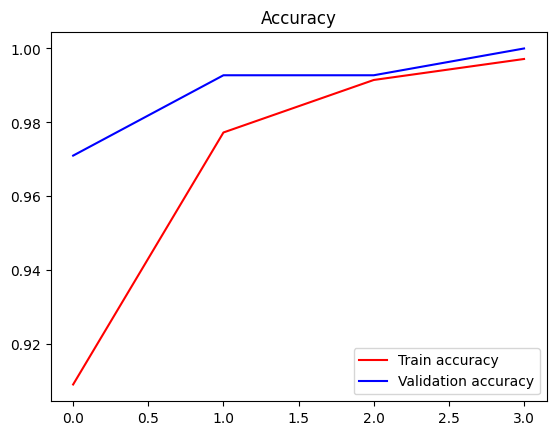

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r', label='Train accuracy')  # Add label for train curve
plt.plot(hist.history['val_accuracy'], 'b', label='Validation accuracy')  # Add label for validation curve
plt.legend()  # Add legend to the plot
plt.show()

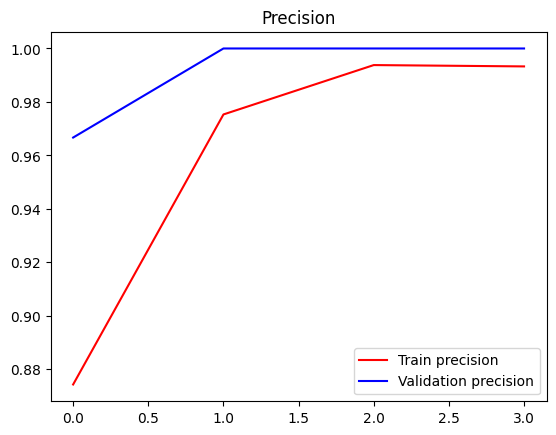

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r', label='Train precision')  # Add label for train curve
plt.plot(hist.history['val_precision'], 'b', label='Validation precision')  # Add label for validation curve
plt.legend()  # Add legend to the plot
plt.show()

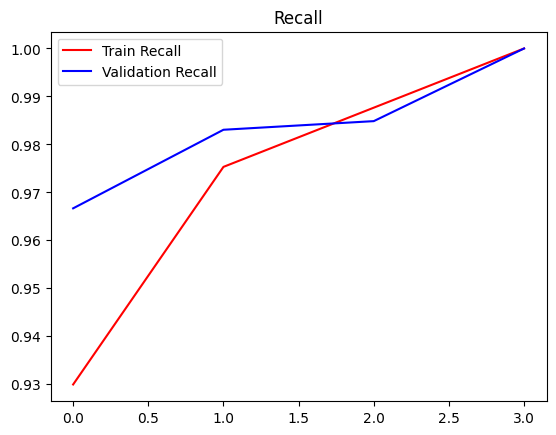

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r', label='Train Recall')  # Add label for train curve
plt.plot(hist.history['val_recall'], 'b', label='Validation Recall')  # Add label for validation curve
plt.legend()  # Add legend to the plot
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
y_test.shape

(16,)

In [ ]:
X_test.shape

(16, 1491, 257, 1)

In [ ]:
yhat = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


## 8.2 Convert Logits to Classes

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat

[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]

In [ ]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=7>

In [ ]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

# 9. Build Test Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('/content/drive/MyDrive/Colab Notebooks/Test Recordings/recording_04.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 6s 6s/step


In [ ]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

4

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/Test Recordings')):
    FILEPATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/Test Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 [==============================] - 5s 5s/step


In [ ]:
results

{'recording_01.mp3': array([[8.9788763e-04],
        [3.7176036e-03],
        [4.2033342e-05],
        [5.5652516e-05],
        [9.8197104e-04],
        [6.6899497e-04],
        [7.2631106e-04],
        [4.4707456e-03],
        [1.9210401e-04],
        [1.8564325e-03],
        [7.4567818e-03],
        [4.7356747e-03],
        [3.2709639e-03],
        [2.5357148e-02],
        [1.8984564e-03],
        [1.8820500e-02],
        [6.0379421e-03],
        [4.4438355e-03],
        [1.3967454e-02],
        [7.7505591e-03],
        [4.4558174e-03],
        [2.0394078e-02],
        [1.1791796e-03],
        [2.7508135e-03],
        [9.2473403e-03],
        [1.1665798e-02],
        [1.0807553e-03],
        [2.8833780e-03],
        [2.1399558e-02],
        [9.6698094e-04],
        [2.7350388e-03],
        [1.6133446e-03],
        [1.9809957e-04],
        [3.7089331e-04],
        [4.9975001e-06],
        [1.4667776e-03],
        [6.5311522e-04],
        [1.2290711e-03],
        [4.3392589e-04],
     

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_00.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_00.mp3': 5,
 'recording_09.mp3': 0,
 'recording_04.mp3': 4,
 'recording_11.mp3': 3,
 'recording_18.mp3': 3,
 'recording_14.mp3': 0,
 'recording_13.mp3': 0,
 'recording_06.mp3': 5,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_19.mp3': 0,
 'recording_12.mp3': 0,
 'recording_05.mp3': 0,
 'recording_10.mp3': 5,
 'recording_08.mp3': 23,
 'recording_15.mp3': 2,
 'recording_07.mp3': 2,
 'recording_23.mp3': 5,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_30.mp3': 3,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_25.mp3': 11,
 'recording_22.mp3': 2,
 'recording_31.mp3': 1,
 'recording_29.mp3': 0,
 'recording_28.mp3': 13,
 'recording_24.mp3': 0,
 'recording_43.mp3': 5,
 'recording_39.mp3': 5,
 'recording_42.mp3': 0,
 'recording_38.mp3': 1,
 'recording_35.mp3': 0,
 'recording_41.mp3': 0,
 'recording_34.mp3': 4,
 'recording_4

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'Fraud_instances'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [ ]:
!dir

# 12. Save model

In [ ]:
import pickle
with open('call_classifier.pkl','wb') as file:
  pickle.dump(model, file)



In [ ]:
with open('call_classifier.pkl','rb') as file:
  clf = pickle.load(file)

In [ ]:
clf.predict('/content/drive/MyDrive/Colab Notebooks/Test Recordings/recording_04.mp3')

In [ ]:
#import os.path
#if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/Saved models/Call_classification.h5') is False:
#  model.save('/content/drive/MyDrive/Colab Notebooks/Saved models/Call_classification.h5')

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Saved models/Call_classification.h5')

In [ ]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 744, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 371, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 368032)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
json_string = model.to_json()

In [ ]:
json_string

In [ ]:
# model reconstruction from JSON:
from tensorflow.keras.models import model_from_json
model_architecture = model_from_json(json_string)

In [ ]:
model_architecture.summary()

Save the trained mode

In [ ]:
import gradio as gr

In [ ]:
def greet(call_class):
  return "This is a Fraud call"

iface = gr.Interface(fn=greet, inputs="audio", outputs="text", title="Call classifier")
iface.launch()

In [ ]:
import pickle

In [ ]:
with open('call_classification', 'wb') as call_class:
  pickle.dump(model, call_class)

In [ ]:
with open('call_classification', 'rb') as call_class:
  mp = pickle.load(call_class)

In [ ]:
mp.summary()

In [ ]:
import joblib

In [ ]:
joblib.dump(call_class, "Call_class.pkl")

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
model.predict(audio_slices)

In [ ]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved models/Call_classification.h5')



# Load the audio file
audio_path = '/content/drive/MyDrive/Colab Notebooks/data/Vishing_calls_snippets/XC114131-3.wav'
waveform, sample_rate = tf.audio.decode_wav(tf.io.read_file(audio_path))

# Preprocess the audio data
# Example: Convert the audio waveform to a spectrogram
spectrogram = tf.signal.stft(waveform, frame_length=2048, frame_step=512)

# Convert to decibel values
log_spectrogram = tf.math.log(tf.abs(spectrogram) + 1e-6)

# Ensure the input shape matches the model's expected input shape
input_data = tf.reshape(log_spectrogram, (1, log_spectrogram.shape[0], log_spectrogram.shape[1], 1))

# Ensure the input_data shape matches the model's input shape
model_input_shape = model.input_shape
if input_data.shape != model_input_shape:
    raise ValueError(f"Input data shape {input_data.shape} does not match model input shape {model_input_shape}")

# Make predictions
predictions = model.predict(input_data)

# Perform post-processing and interpretation as needed
# Example: Apply thresholding to identify the presence of calls
threshold = 0.5  # Define a threshold for call presence
calls = (predictions > threshold).astype(int)

# Count the number of calls
number_of_calls = np.sum(calls)

# Print the result
print("Number of calls in the audio: ", number_of_calls)



ValueError: Input data shape (1, 144000, 0, 1) does not match model input shape (None, 1491, 257, 1)

In [ ]:
X_test.shape

(16, 1491, 257, 1)

In [ ]:
predictions = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [ ]:
threshold = 0.99  # Define a threshold for call presence
calls = (predictions > threshold).astype(int)

# Count the number of calls
number_of_calls = np.sum(calls)

# Print the result
print("Number of calls in the audio: ", number_of_calls)

Number of calls in the audio:  8
